In [1]:
import xmltodict, json, feedparser
from urllib.request import urlopen
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
import time, re
import pandas as pd
from collections import defaultdict
import json
from datetime import datetime
from selenium.webdriver.common.by import By
from pprint import pprint
import dataframe_image as dfi
import os, sys
from PIL import Image
import cv2
import math
from datetime import datetime
from datetime import date
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.remote.webelement import WebElement
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import matplotlib.dates as mdates
from ast import literal_eval
import requests
import cv2
from io import BytesIO
from zipfile import ZipFile
import xml.etree.ElementTree as ET
from ast import literal_eval
from urllib import parse
from dateutil.relativedelta import relativedelta
import numpy as np

import ssl
context = ssl._create_unverified_context()


plt.rcParams['axes.unicode_minus'] = False
path = 'C:/Windows/Fonts/H2GTRM.TTF' # H2GTRM
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font', family=font_name)
crtfc_key = '0a8c798b97ddd067012cb38f15aa6252a82d9f13'
url_corpcode = 'https://opendart.fss.or.kr/api/corpCode.xml?crtfc_key={}'.format(crtfc_key)

with urlopen(url_corpcode, context=context) as zip_response:
    with ZipFile(BytesIO(zip_response.read())) as zfile:
        zfile.extractall()

tree = ET.parse('corpcode.xml')
root = tree.getroot()

def find_stock_code(find_name):
    for company in root.iter('list'):                                                                          
        if company.findtext('corp_name') == find_name:
            if company.findtext('stock_code').isspace(): # None
                continue
            else:
                return company.findtext('stock_code')

def get_sise(code, start_time, end_time, time_from='day') :
        get_param = {
            'symbol':code,
            'requestType':1,
            'startTime':start_time,
            'endTime':end_time,
            'timeframe':time_from
        }
        get_param = parse.urlencode(get_param)
        url="https://api.finance.naver.com/siseJson.naver?%s"%(get_param)
        response = requests.get(url)
        return literal_eval(response.text.strip())

end = datetime.today().strftime('%Y%m%d')
start = (date.today() + relativedelta(months=-36)).strftime('%Y%m%d')

대신밸런스제13호기업인수목적(상장) 새로운 공시
('2022-11-28', '대신밸런스제13호기업인수목적(상장)', '상장일', 'images/IPO_대신밸런스제13호기업인수목적.png')
2022-11-22 08:33:32.842757
기존에 있는 공시
2022-11-22 08:43:39.551448
기존에 있는 공시
2022-11-22 08:53:46.197201
기존에 있는 공시
2022-11-22 09:03:50.580098
기존에 있는 공시
2022-11-22 09:13:57.288418
기존에 있는 공시
2022-11-22 09:24:03.959131
기존에 있는 공시
2022-11-22 09:34:10.592400
51
try2022-11-22 삼성중공업 images/supplytable/삼성중공업_concat_2022-11-22.png
삼성중공업 새로운 공시
('2022-11-22', '삼성중공업', '단일판매ㆍ공급계약체결', 'images/supplytable/삼성중공업_concat_2022-11-22.png')
23
try2022-11-22 SNT에너지 images/supplytable/SNT에너지_concat_2022-11-22.png
SNT에너지 새로운 공시
('2022-11-22', 'SNT에너지', '단일판매ㆍ공급계약체결', 'images/supplytable/SNT에너지_concat_2022-11-22.png')
기존에 있는 공시
2022-11-22 09:57:28.777764
2022-11-22 10:07:28.813200
인선이엔티 새로운 공시
('2022-11-23', '인선이엔티', '회사 주요현황 설명을 통한 투자자 이해 증진', 'https://dart.fss.or.kr/api/link.jsp?rcpNo=20221122900086')
51
try2022-11-22 삼성중공업 images/supplytable/삼성중공업_concat_2022-11-22.png
기존에 있는 공시
23
try2022-11-22 SNT에너지 ima

KeyboardInterrupt: 

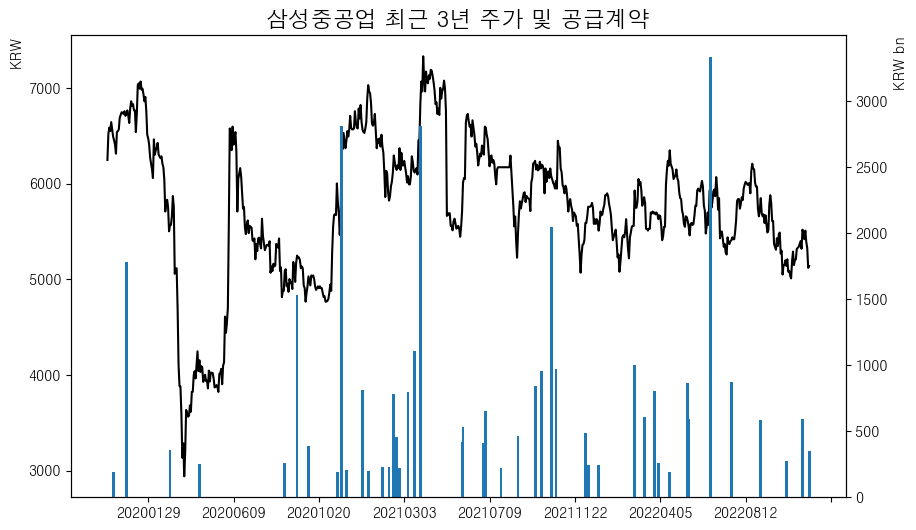

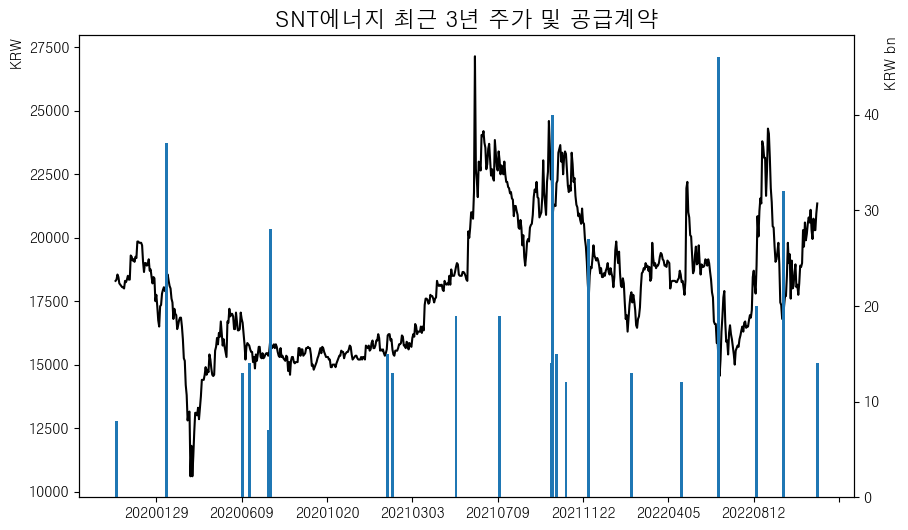

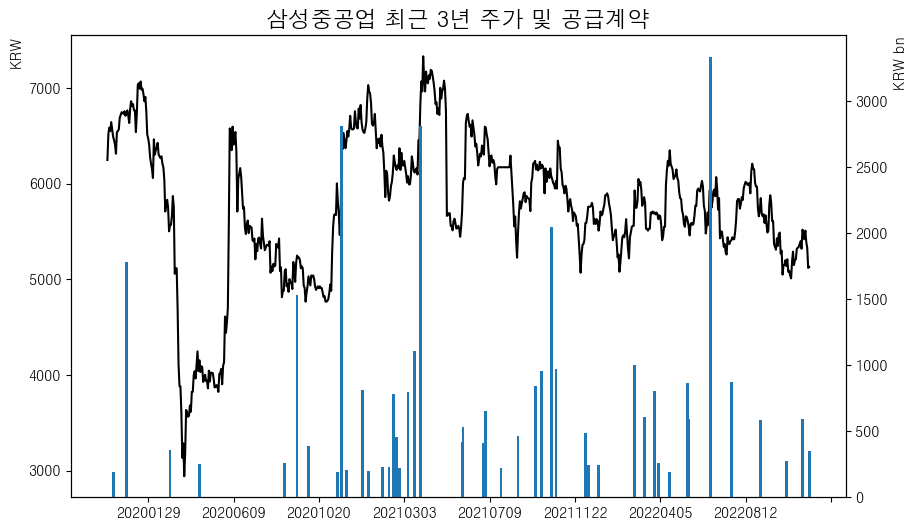

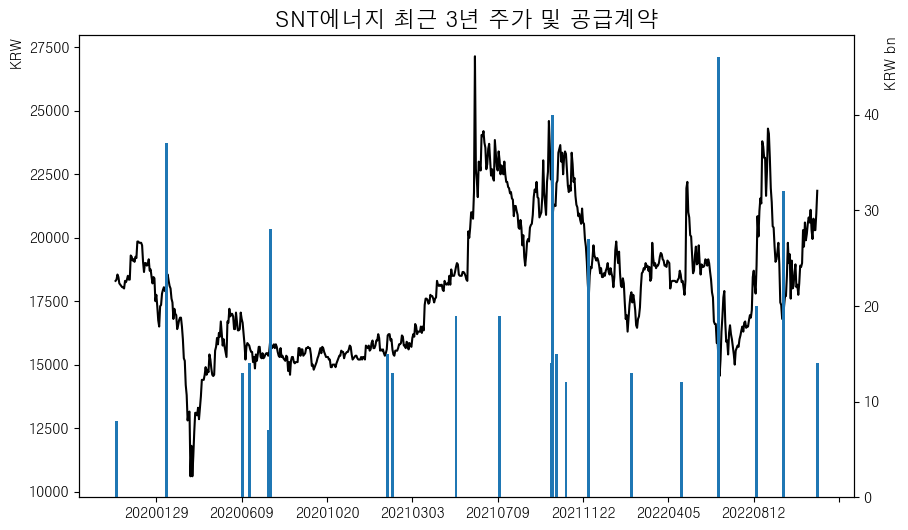

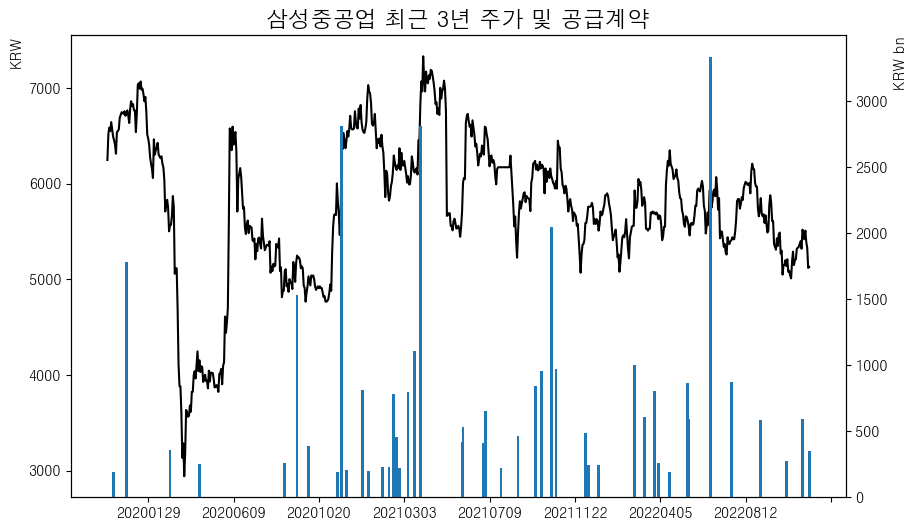

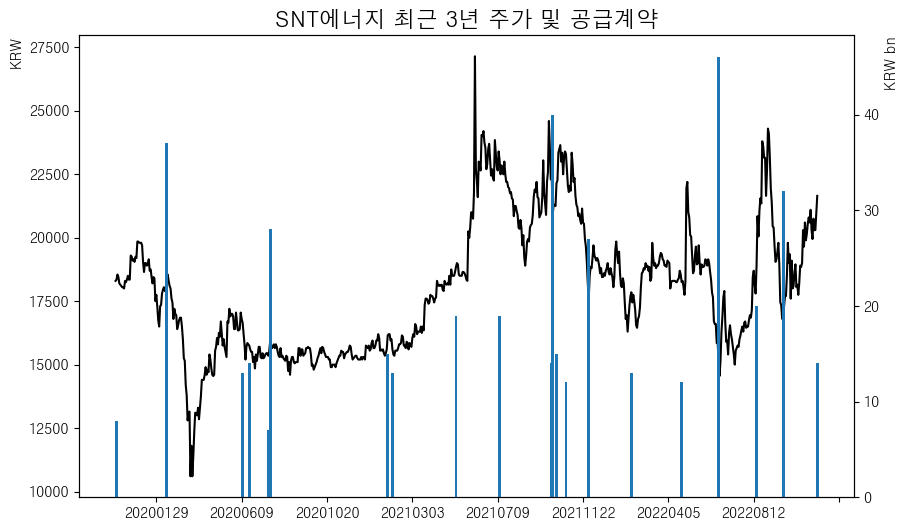

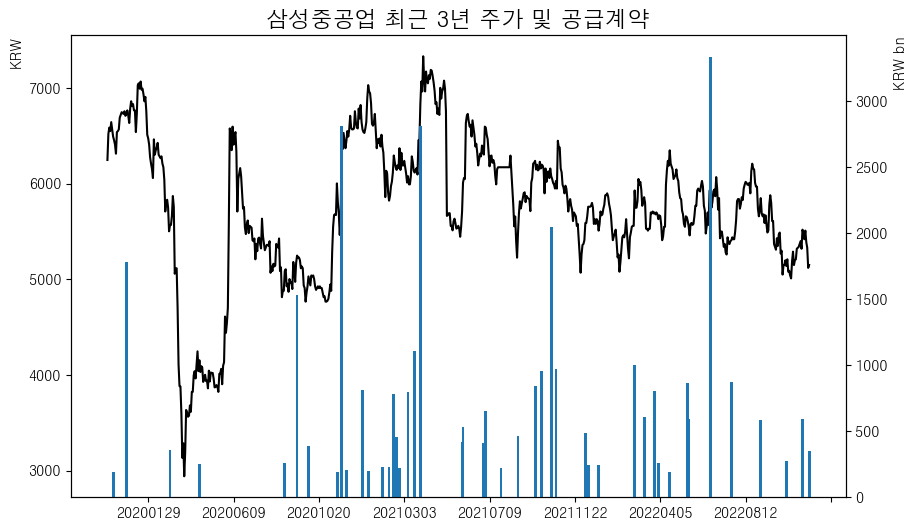

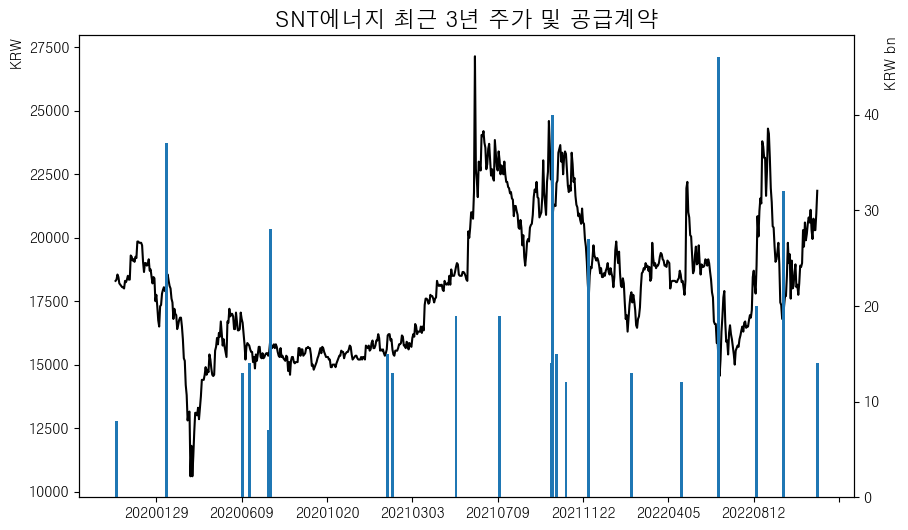

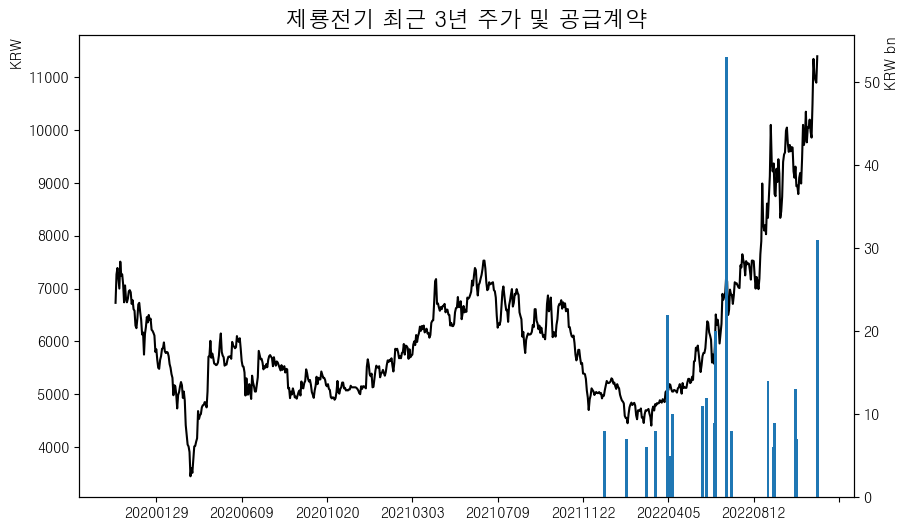

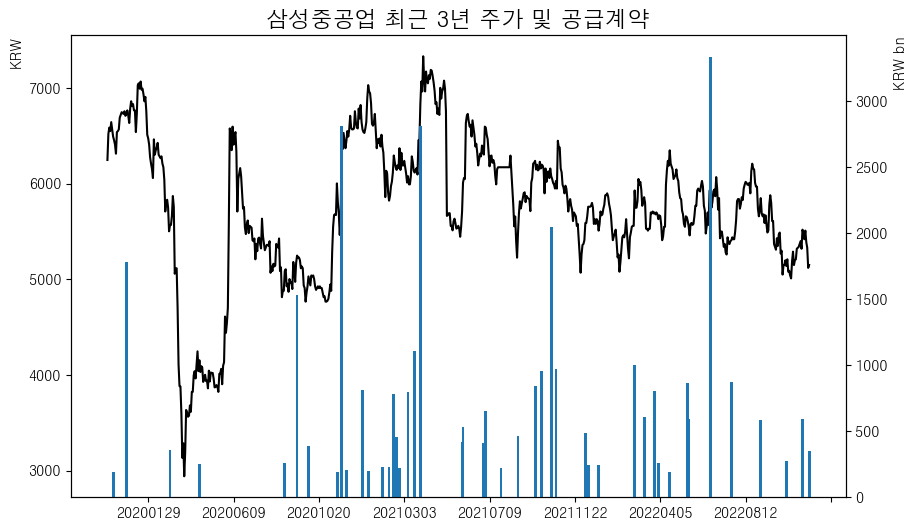

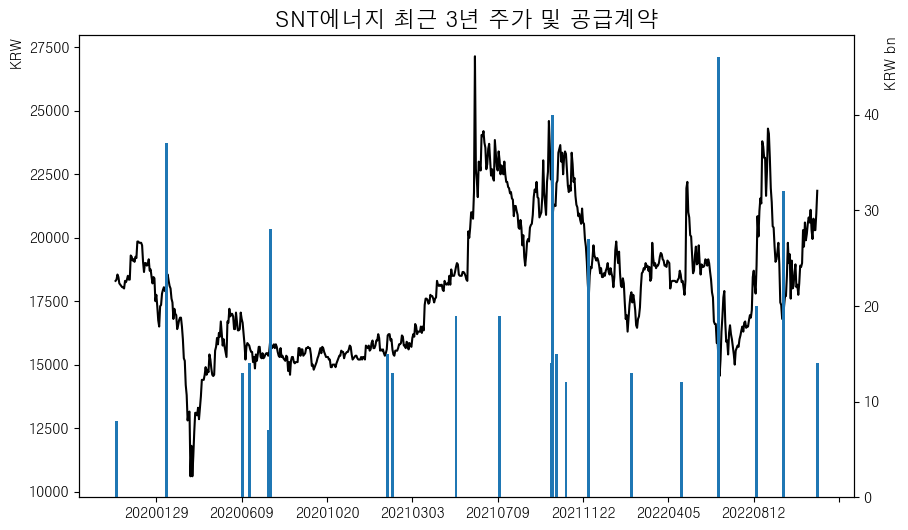

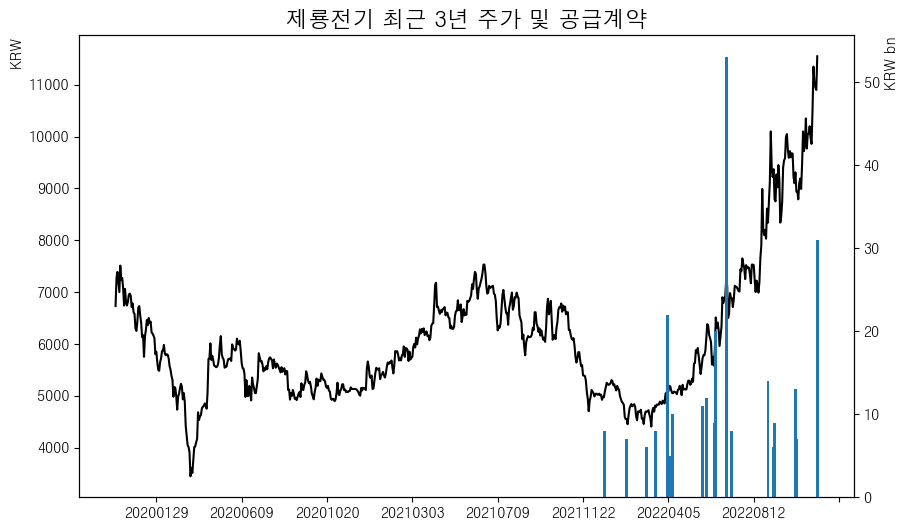

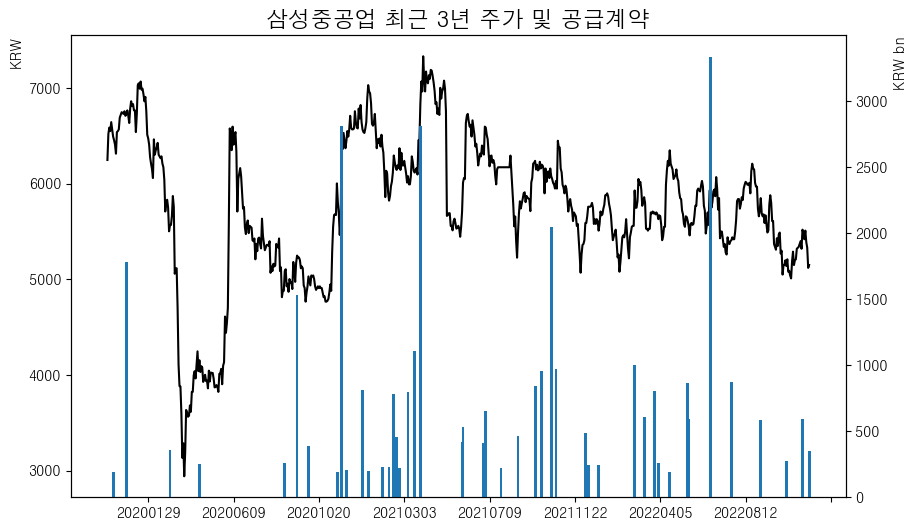

In [2]:
###############  IPO 합치는 작업 중  #######################  IR, IPO(투자설명서, 청약일자) 완료 / 상장일 작업 중

def add_entry(res, date, companyName, text, link):

  seen = set()

  for dateRes in res.keys():
    for company in res[dateRes].keys():
      seen.add((date, company, res[dateRes][company]['내용'], res[dateRes][company]['링크']))

  # check if in seen set
  if (date, companyName, text, link) in seen:
    print('기존에 있는 공시')
    return res

  # add to seen set
  print(companyName, '새로운 공시')
  seen.add(tuple([date, companyName, text, link]))
  print(tuple([date, companyName, text, link]))

  # append to results list
  try:
    res[date][companyName] = {'내용': text, '링크': link}
  except:
    res[date] = {companyName: {'내용': text, '링크': link}} # 해당날짜의 첫 번째 데이터
  return res


def makeCalendar():
  
  while True:
    
    rss_info = feedparser.parse('https://dart.fss.or.kr/api/todayRSS.xml')
    disclosure_list = rss_info['entries']

    for disclosure in disclosure_list:
      companyName = disclosure['author']
      link = disclosure['link']
      link = link.replace('http', 'https')
      title = disclosure['title']

      # datePublished = disclosure['published']  # 'published_parsed'
      dateObj = datetime.strptime(str(datetime.today()), '%Y-%m-%d %H:%M:%S.%f')  # format code를 이용하여 datetime object로 변환
      date = dateObj.strftime('%Y-%m-%d')  # 문자열로 변환

      if ('기업설명회(IR)' in title) and not('안내공시' in title or '정정' in title):  #코스닥

        option = Options()
        option.add_argument('headless')
        driver = webdriver.Chrome(options=option)
        driver.get(link)
        # time.sleep(2)
        html_source = driver.page_source

        rcpNo = re.findall(r"openPdfDownload\('(.*?)', '", html_source)
        dcmNo = re.findall(r"', '(.*?)'\);", html_source)

        # url이 있어야 read_html을 통해 table 가져올 수 있다
        frame_url = 'https://dart.fss.or.kr/report/viewer.do?rcpNo=' + rcpNo[0] + '&dcmNo=' + dcmNo[2][0:7] + '&eleId=' + '0' + '&offset=' + '0' + '&length=' + '0' + '&dtd=HTML'

        table_ifrm = pd.read_html(frame_url, index_col=0)#, header=None)
        calendarDB = 'calendarDB.json'
      
        for index, row in table_ifrm[0].iterrows():
          if '목적' in index:
            text = row[2]
            if ('실적' in text) and not('설명' in text):
              companyName = companyName + '(실적발표)'
              calendarDB = 'earningsDB.json'
        for index, row in table_ifrm[0].iterrows():
          if '일시' in index:
            if '20' in row[2]:
              dateRelease = row[2]

        try:
          with open(calendarDB, encoding='utf-8') as db:
            res = json.load(db)
          args = [dateRelease, companyName, text, link]
          res = add_entry(res, *args)
          with open(calendarDB, 'w', encoding='utf-8') as db:
            json.dump(res, db, ensure_ascii=False)
        except:
          pass

      elif ('기업설명회(IR)개최(안내공시)' in title) and not('정정' in title):  # 코스피

        option = Options()
        option.add_argument('headless')
        driver = webdriver.Chrome(options=option)
        driver.get(link)
        # time.sleep(2)
        html_source = driver.page_source

        rcpNo = re.findall(r"openPdfDownload\('(.*?)', '", html_source)
        dcmNo = re.findall(r"', '(.*?)'\);", html_source)

        # url이 있어야 read_html을 통해 table 가져올 수 있다
        frame_url = 'https://dart.fss.or.kr/report/viewer.do?rcpNo=' + rcpNo[0] + '&dcmNo=' + dcmNo[2][0:7] + '&eleId=' + '0' + '&offset=' + '0' + '&length=' + '0' + '&dtd=HTML'

        table_ifrm = pd.read_html(frame_url, index_col=0)#, header=None)
        calendarDB = 'calendarDB.json'

        text = table_ifrm[0].loc['3. 개최목적', 2]
        
        if ('실적' in text) and not('설명' in text):
          companyName = companyName + '(실적발표)'
          calendarDB = 'earningsDB.json'
        
        dateRelease = table_ifrm[0].loc['1. 일시 및 장소', 2][0]

        try:
          with open(calendarDB, encoding='utf-8') as db:
            res = json.load(db)
          args = [dateRelease, companyName, text, link]
          res = add_entry(res, *args)
          with open(calendarDB, 'w', encoding='utf-8') as db:
            json.dump(res, db, ensure_ascii=False)
        except:
          pass

      elif ('결산실적공시예고' in title) and not('정정' in title):

        option = Options()
        option.add_argument('headless')
        driver = webdriver.Chrome(options=option)
        driver.get(link)
        # time.sleep(2)
        html_source = driver.page_source

        rcpNo = re.findall(r"openPdfDownload\('(.*?)', '", html_source)
        dcmNo = re.findall(r"', '(.*?)'\);", html_source)

        # url이 있어야 read_html을 통해 table 가져올 수 있다
        frame_url = 'https://dart.fss.or.kr/report/viewer.do?rcpNo=' + rcpNo[0] + '&dcmNo=' + dcmNo[2][0:7] + '&eleId=' + '0' + '&offset=' + '0' + '&length=' + '0' + '&dtd=HTML'

        table_ifrm = pd.read_html(frame_url, index_col=0)#, header=None)

        for index, row in table_ifrm[0].iterrows():
          if '공시예정일' in index:
            dateRelease = row[2]
            text = title
            companyName = companyName + '(실적발표)'

        try:
          with open('calendarDB.json', encoding='utf-8') as db:
            res = json.load(db)
          args = [dateRelease, companyName, text, link]
          res = add_entry(res, *args)
          with open('calendarDB.json', 'w', encoding='utf-8') as db:
            json.dump(res, db, ensure_ascii=False)
        except:
          pass

      elif ('투자설명서' in title) and not('일괄신고' in title or '정정' in title):

        try:

          # text = title
          # print(title)
          dateNew = date
          
          # 증권발행실적보고서 나오는 상장일이 정해지면 상장일 날짜에 올릴 png 파일을 만드는 작업 ***************************
          option = Options()
          option.add_argument('--window-size=1920,1080')
          option.add_argument('headless')
          driver = webdriver.Chrome(options=option)
          driver.get(link)
          # time.sleep(2)

          key_word = [['제1부', '_'],['사업의 내용', '매출 및 수주상황'], ['투자위험요소', '유통가능']]
          dictIPO = {}

          for kw in key_word:

            driver.find_element(By.PARTIAL_LINK_TEXT, kw[0]).click()

            driver.current_url
            html_source = driver.page_source
            bk, kw[0], ak = html_source.partition(kw[0])

            rcpNo = re.findall(r'rcpNo\'] = "(.*?)";\n', ak)
            dcmNo = re.findall(r'dcmNo\'] = "(.*?)";\n', ak)
            eleId = re.findall(r'eleId\'] = "(.*?)";\n', ak)
            offset = re.findall(r'offset\'] = "(.*?)";\n', ak)
            length = re.findall(r'length\'] = "(.*?)";\n', ak)
            dtd = re.findall(r'dtd\'] = "(.*?)";\n', ak)

            # url이 있어야 read_html을 통해 table 가져올 수 있다
            frame_url = 'https://dart.fss.or.kr/report/viewer.do?rcpNo=' + rcpNo[0] + '&dcmNo=' + dcmNo[0] + '&eleId=' + eleId[0] + '&offset=' + offset[0] + '&length=' + length[0] + '&dtd=' + dtd[0]
            
            if (kw[0] == '사업의 내용'):
              link2 = frame_url
            elif (kw[0] == '제1부'):
              table_ifrm = pd.read_html(frame_url)  # , index_col=0, header=0)
              try:
                dateRaw = re.sub(r'[\[\]\'~\s+]+', '', str(table_ifrm[3].iloc[:, 0].values))
                dateRaw2 = dateRaw[:math.floor(len(dateRaw)/2)]
              except:
                dateRaw2 = dateRaw[:math.ceil(len(dateRaw)/2)]

              dateObj = datetime.strptime(dateRaw2, '%Y년%m월%d일')  # format code를 이용하여 datetime object로 변환
              dateSubscribe = dateObj.strftime('%Y-%m-%d')  # 문자열로 변환
              print('청약일 발췌 완료', dateSubscribe)
              companyNameSubscribe = companyName + '(청약)'
              continue
            else:
              pass

            driver.get(frame_url)

            driver.current_url
            text_source = driver.page_source
            bk2, kw[1], ak2 = text_source.partition(kw[1])

            table_ifrm = pd.read_html(io=ak2, index_col=0, header=0, thousands='.', decimal='.')  # 아무리 봐도 이해가 안 감
            dictIPO[kw[0]] = table_ifrm
            
            driver.get(link)  # for loop를 위해 다시 링크를 열어줘야 함

            
          for no in range(len(dictIPO[key_word[1][0]])):
            done = ''
            for index, row in dictIPO[key_word[1][0]][no].iterrows():
              try:
                if '계' in index:
                  tableUnit = dictIPO[key_word[1][0]][no-1]
                  tableSales =  dictIPO[key_word[1][0]][no]
                  done = True
                  print('사업의 내용: 이상무')
                  break
                else: pass
              except:
                print('사업의 내용: 문제 발생')
                pass
            if done:  # 조건에 해당하는 첫번째 테이블을 가져오기 위해서 break
              break

          for no in range(len(dictIPO[key_word[2][0]])):
            done = ''
            for index, row in dictIPO[key_word[2][0]][no].iterrows():
              try:
                if '최대주주' in index:
                  tableOverhang =  dictIPO[key_word[2][0]][no]
                  done = True
                  print('투자위험요소: 이상무')
                  break
                elif '유통제한' in index:
                  tableOverhang =  dictIPO[key_word[2][0]][no]
                  done = True
                  print('투자위험요소: 이상무')
                  break
                else: pass
              except:
                print('투자위험요소: 문제발생')
                pass
            if done:
              break

          listTableNames = [tableUnit, tableSales, tableOverhang]
          listPictures = ['images/unit_' + companyName + '.png', 'images/sales_' + companyName + '.png', 'images/overhang_' + companyName + '.png']
            
          for item in zip(listTableNames, listPictures):
            dfi.export(item[0], item[1])
            im = Image.open(item[1])
            im.thumbnail((2000, 2000), Image.ANTIALIAS)
            im.save(item[1])

          images = [Image.open(x) for x in ['images/unit_' + companyName + '.png', 'images/sales_' + companyName + '.png', 'images/overhang_' + companyName + '.png', 'images/black.png']]
          widths, heights = zip(*(i.size for i in images))
          maxWidth = max(widths)
          totalHeight = sum(heights) + 30

          new_im = Image.new('RGB', (maxWidth, totalHeight))
          y_offset = 0
          for im in images:
            if im == images[0]:
              new_im.paste(im, (0, y_offset))
              y_offset += im.size[1] + 3
            else:
              new_im.paste(im, (0, y_offset))
              y_offset += im.size[1] + 20
          new_im.save('images/IPO_' + companyName + '.png')
          print(companyName, '상장일 이미지 파일 완성')

          try:
            with open('IPODB.json', encoding='utf-8') as db:
              res = json.load(db)
            args = [dateNew, companyName, text, link]
            argsSubscribe = [dateSubscribe, companyNameSubscribe, text, link]
            res = add_entry(res, *args)
            res = add_entry(res, *argsSubscribe)
            with open('IPODB.json', 'w', encoding='utf-8') as db:
              json.dump(res, db, ensure_ascii=False)
          except:
            print('DB관련 문제발생')
            pass

        except:
          continue

      elif ('증권발행실적보고서' in title) and not('정정' in title):
        try:
          option = Options()
          option.add_argument('headless')
          option.add_argument('--window-size=1920,1080')
          driver = webdriver.Chrome(options=option)
          driver.get(link)
          # time.sleep(2)

          key_word = '증권교부일'
          driver.find_element(By.PARTIAL_LINK_TEXT, key_word).click()

          driver.current_url
          html_source = driver.page_source
          bk, key_word, ak = html_source.partition(key_word)

          rcpNo = re.findall(r'rcpNo\'] = "(.*?)";\n', ak)
          dcmNo = re.findall(r'dcmNo\'] = "(.*?)";\n', ak)
          eleId = re.findall(r'eleId\'] = "(.*?)";\n', ak)
          offset = re.findall(r'offset\'] = "(.*?)";\n', ak)
          length = re.findall(r'length\'] = "(.*?)";\n', ak)
          dtd = re.findall(r'dtd\'] = "(.*?)";\n', ak)

          # url이 있어야 read_html을 통해 table 가져올 수 있다
          frame_url = 'https://dart.fss.or.kr/report/viewer.do?rcpNo=' + rcpNo[0] + '&dcmNo=' + dcmNo[0] + '&eleId=' + eleId[0] + '&offset=' + offset[0] + '&length=' + length[0] + '&dtd=' + dtd[0]
          driver.get(frame_url)
          driver.current_url
          html_source = driver.page_source
          
          # dateListingRaw = '2022년' + re.sub(r'[\[\]\'\s+]', '', str(re.findall(r"년(.*?)\(예정\)", html_source)[1]))  # 년도를 바꿔줘야 하는데...
          
          dateListingRaw = re.sub(r'[\[\]\'\s+]', '', str(re.findall(r"상장일\(매매개시일\)<br></span><br>(.*?)\(예정\)", html_source)))

          try:
            dateObj = datetime.strptime(dateListingRaw, '%Y년%m월%d일')  # format code를 이용하여 datetime object로 변환
          except:
            dateListingRaw = re.sub(r'[\[\]\'\s+]', '', str(re.findall(r":(.*?)\(예정\)", html_source)[1]))
            dateObj = datetime.strptime(dateListingRaw, '%Y년%m월%d일')  # format code를 이용하여 datetime object로 변환


          dateListing = dateObj.strftime('%Y-%m-%d')  # 문자열로 변환
          companyName2 = companyName + '(상장)'
          text = '상장일'
          
          try:
            link = 'images/IPO_' + companyName + '.png'  # IPO_기업명 파일 연결
          except:
            pass

          try:
            with open('IPODB.json', encoding='utf-8') as db:
              res = json.load(db)
            args = [dateListing, companyName2, text, link]
            res = add_entry(res, *args)
            with open('IPODB.json', 'w', encoding='utf-8') as db:
              json.dump(res, db, ensure_ascii=False)
          except:
            pass

        except:
          print('증권발행실적보고서 관련 문제발생')
          pass
      
      elif ('단일판매' in title) and not('기재정정' in title or '자회사' in title or '자율공시' in title):
        # companyName = '피엔티'  # disclosure['author']
        stockCode = find_stock_code(companyName)
        sise_list = get_sise(stockCode, start, end, 'day')
        dfSise = pd.DataFrame(sise_list[1:], columns=sise_list[0])
        dfSise.index = dfSise['날짜']
        dfSise.index.name = 'Date'
        dfSise.drop('날짜', axis=1, inplace=True)

        option = Options()
        option.add_argument('headless')
        driver = webdriver.Chrome(options=option)
        
        # driver = webdriver.Chrome()
        driver.get('https://dart.fss.or.kr/dsab007/main.do?option=corp')
        driver.maximize_window()
        time.sleep(3)

        stockCodeBox = driver.find_element('id', 'textCrpNm')
        stockCodeBox.send_keys(stockCode)
        driver.find_element('id', 'date5').click()  # 3년 클릭
        driver.find_element('id', 'btnPlus').click()  # 상세조건열기 클릭
        # driver.find_element(By.PARTIAL_LINK_TEXT, '상세조건열기').click()  # 상세조건열기 클릭
        reportNameBox = driver.find_element('id', 'reportName2')
        reportNameBox.send_keys('단일판매ㆍ공급계약체결')

        # -------- 드롭다운 메뉴 100개로 선택 -------------------
        dropdown = Select(driver.find_element('id', 'maxResultsCb'))
        dropdown.select_by_value('100')

        # -------- div style:block 처리 -------------------
        driver.find_element(By.CSS_SELECTOR, "a[class='btnSearch']").click()  # 검색 클릭
        # time.sleep(1)

        # a = driver.find_element(By.CSS_SELECTOR, "div[class='searchPop wrapM']")
        # print(a.get_attribute('innerHTML'))
        # a.click()

        checkBox = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.ID, 'allCheck')))
        checkBox.click()  # 체크박스(all) 클릭
        driver.find_element('xpath', '/html/body/div[15]/div[2]/div[2]/div[2]/a[1]').click()  # 확인 클릭

        # -------- 마무리 검색 클릭 -------------------
        driver.find_element('xpath', '/html/body/div[4]/div[2]/div[1]/div[2]/div[2]/form[2]/div[2]/div[2]/a[1]').click()  # 검색 다시 클릭
        # driver.find_element(By.CSS_SELECTOR, "a[class='btnSearch']").click()  # 작동이 안 됨...이상
        time.sleep(1)  # 검색 데이터가 하단에 부착 되는데 필요한 시간


        # table = driver.find_element(By.CSS_SELECTOR, "table[class='tbList']")
        # table = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "table[class='tbList']")))
        # print("------------table---------------", table.get_attribute('innerHTML'))

        tbody = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.ID, 'tbody')))
        # a = driver.find_element(By.PARTIAL_LINK_TEXT, '제룡전기')
        tbodyCode = tbody.get_attribute('innerHTML')
        links = re.findall(r'id="r_(.*?)"', tbodyCode)
        # links = re.findall(r'id="r_', tbodyCode)
        print(len(links))
        # tbodyCode = tbody.get_attribute('href')
        # links = [tbody.get_attribute('href') for elem in tbody]
        # print(links)
        # print(tbodyCode)
        # print("---------------a-----------------------", tbody.get_attribute('innerHTML'))
        # driver.find_element_by_xpath("//p[@id='one']/following-sibling::p")

        linkUrls = ['https://dart.fss.or.kr/dsaf001/main.do?rcpNo=' + link for link in links]
        # print(linkUrls)

        i = 0
        dfSupplyRaw = []
        for url in linkUrls:

          option = Options()
          option.add_argument('headless')
          driver = webdriver.Chrome(options=option)
          driver.get(url)
          time.sleep(1)
          html_source = driver.page_source

          rcpNo = re.findall(r"openPdfDownload\('(.*?)', '", html_source)
          dcmNo = re.findall(r"', '(.*?)'\);", html_source)

          # url이 있어야 read_html을 통해 table 가져올 수 있다
          frame_url = 'https://dart.fss.or.kr/report/viewer.do?rcpNo=' + rcpNo[0] + '&dcmNo=' + dcmNo[2][0:7] + '&eleId=' + '0' + '&offset=' + '0' + '&length=' + '0' + '&dtd=HTML'

          # tableSupply = []
          try:
            tableSupply = pd.read_html(frame_url, index_col=0)
            tableSupply = tableSupply[3]
            tableSupply.index = tableSupply[1]
            tableSupply.drop(1, axis=1, inplace=True)
            # print('try')
          except:
            tableSupply = pd.read_html(frame_url, index_col=0)
            tableSupply = tableSupply[0]
            tableSupply.index = tableSupply[1]
            tableSupply.drop(1, axis=1, inplace=True)
            # print('except')

          # print(i, url)

          keyword = 'https://dart.fss.or.kr/dsaf001/main.do?rcpNo='
          bk, keyword, ak = url.partition(keyword)
          contractDate = ak[0:8]
          contractDate2 = f'{contractDate[0:4]}-{contractDate[4:6]}-{contractDate[6:8]}'
          contractAmount, latestSales, contractSalesRatio, beginningDay, endingDay, supplyPeriod, counterpart, region = '', '', '', '', '', '', '', ''

          for index, row in tableSupply.iterrows():
            if '계약금액' in index:
              # contractAmount = f'{int(row[2]):,}'
              try:
                contractAmount = round(int(row[2])/1000000000)
                break
              except:
                contractAmount = 0
                break
          for index, row in tableSupply.iterrows():
            if '매출액' in index:
              latestSales = round(int(row[2])/1000000000)
              break
          for index, row in tableSupply.iterrows():
            if '%' in index:
              try:
                contractSalesRatio = float(f'{round(float(row[2]), 1):,}')
                break
              except:
                contractSalesRatio = 0
          try:
            for index, row in tableSupply.iterrows():
              if '상대' in index:
                if row[2] == '-':
                  pass
                else:
                  counterpart = row[2]
                  break
          except:
            print('상대방 관련 오류')
          for index, row in tableSupply.iterrows():
            if '지역' in index:
              region = row[2]
              break
          for index, row in tableSupply.iterrows():
            if '시작' in index:
              beginningDay = row[2]
              break
          for index, row in tableSupply.iterrows():
            if '종료' in index:
              endingDay = row[2]
              break
          
          try:
            delta = datetime.strptime(endingDay, '%Y-%m-%d')-datetime.strptime(beginningDay, '%Y-%m-%d')
            supplyPeriod = float(delta.days/365)
          except:
            supplyPeriod = None
          dfSupplyRaw.append([contractDate, contractAmount, latestSales, contractSalesRatio, beginningDay, endingDay, supplyPeriod, counterpart, region])

          i = i + 1
          time.sleep(5)

        # print(dfSupplyRaw)
        dfSupply = pd.DataFrame(dfSupplyRaw, columns=['날짜', '계약금액(십억)', '최근매출액(십억)', '매출액대비(%)', '시작일', '종료일', '기간(년)', '계약상대방', '공급지역'])
        dfSupply.index = dfSupply['날짜']
        dfSupply.index.name = 'Date'
        dfSupply.index = pd.to_datetime(dfSupply.index, format = '%Y-%m-%d').strftime('%Y%m%d')
        dfSupply.drop('날짜', axis=1, inplace=True)
        
        dfFinal = dfSise.join(dfSupply, how='left', on='Date').fillna(0)  # 같은 날짜 공급계약 복수 처리 미완성

        # print(dfSupply)
        # print(dfFinal)

        plt.rc('figure', figsize=(10, 6))
        fig, axes = plt.subplots(1, 1)
        plt.ylabel('KRW', fontsize=10, loc='top')
        plt.title(companyName + " 최근 3년 주가 및 공급계약", fontsize=16)
        axes2 = axes.twinx()
        axes2.set_ylabel('KRW bn', fontsize=10, loc='top')
        priceList = dfFinal['종가'].to_numpy()
        contractList = dfFinal['계약금액(십억)'].to_numpy()
        ln1 = axes.plot(dfFinal.index, priceList, 'k-', label = 'price(L)')
        ln2 = axes2.bar(dfFinal.index, contractList, width=3)
        axes.xaxis.set_major_locator(mdates.DayLocator(interval=90))
        plt.savefig('images/supplytable/' + companyName + '_chart_' + datetime.today().strftime("%Y-%m-%d") + '.png')

        dfSupplyTable = pd.DataFrame(dfSupplyRaw, columns=['날짜', '계약금액(십억)', '최근매출액(십억)', '매출액대비(%)', '시작일', '종료일', '기간(년)', '계약상대방', '공급지역'])
        dfSupplyTable.index = dfSupplyTable['날짜']
        dfSupplyTable.index.name = 'Date'
        dfSupplyTable.drop('날짜', axis=1, inplace=True)
        dfSupplyTable.index = pd.to_datetime(dfSupplyTable.index, format = '%Y%m%d').strftime('%Y-%m-%d')
        dfSupplyTable['계약금액(십억)'] = dfSupplyTable['계약금액(십억)'].apply(lambda x: "{:,}".format(x))
        dfSupplyTable['최근매출액(십억)'] = dfSupplyTable['최근매출액(십억)'].apply(lambda x: "{:,}".format(x))

        try:
          dfSupplyTable['기간(년)'] = dfSupplyTable['기간(년)'].round(1)
        except:
          dfSupplyTable['기간(년)'] = np.nan

        dfi.export(dfSupplyTable, 'images/supplytable/' + companyName + '_table_' + datetime.today().strftime("%Y-%m-%d") + '.png')

        images = [Image.open(x) for x in ['images/supplytable/' + companyName + '_chart_' + datetime.today().strftime("%Y-%m-%d") + '.png', 'images/supplytable/' + companyName + '_table_' + datetime.today().strftime("%Y-%m-%d") + '.png']]
        widths, heights = zip(*(i.size for i in images))
        maxWidth = max(widths)
        totalHeight = sum(heights) + 30

        new_im = Image.new('RGB', (maxWidth, totalHeight))
        y_offset = 0
        for im in images:
          if im == images[0]:
            new_im.paste(im, (0, y_offset))
            y_offset += im.size[1] + 10
          else:
            new_im.paste(im, (0, y_offset))
            # y_offset += im.size[1] + 20
        new_im.save('images/supplytable/' + companyName + '_concat_' + datetime.today().strftime("%Y-%m-%d") + '.png')
        link = 'images/supplytable/' + companyName + '_concat_' + datetime.today().strftime("%Y-%m-%d") + '.png'

        try:
          with open('supplyDB.json', encoding='utf-8') as db:
            res = json.load(db)
          print('try'+ date, companyName, link)
          args = [date, companyName, '단일판매ㆍ공급계약체결', link]
          res = add_entry(res, *args)
          with open('supplyDB.json', 'w', encoding='utf-8') as db:
            json.dump(res, db, ensure_ascii=False)
        except:
          pass

      
      else:
        continue
      
    print(datetime.now())
    time.sleep(600)


for i in range(1, 100):
  try:
    makeCalendar()
  except Exception as e:
    print(e)
    print('restarting')
    continue
  else:
    break

datetime.date

In [2]:
###############  IPO 합치는 작업 중  #######################  IR, IPO(투자설명서, 청약일자) 완료

def add_entry(res, date, companyName, text, link):

  seen = set()

  for dateRes in res.keys():
    for company in res[dateRes].keys():
      seen.add((date, company, res[dateRes][company]['내용'], res[dateRes][company]['링크']))

  # check if in seen set
  if (date, companyName, text, link) in seen:
    print('add_entry 사용')
    return res

  # add to seen set
  print(companyName)
  print(datetime.now())
  print('?')
  seen.add(tuple([date, companyName, text, link]))
  
  print(tuple([date, companyName, text, link]))

  # append to results list
  try:
    res[date][companyName] = {'내용': text, '링크': link}
  except:
    res[date] = {companyName: {'내용': text, '링크': link}} # 해당날짜의 첫 번째 데이터

  return res


def makeCalendar():
  
  while True:
    
    rss_info = feedparser.parse('https://dart.fss.or.kr/api/todayRSS.xml')
    disclosure_list = rss_info['entries']

    for disclosure in disclosure_list:
      companyName = disclosure['author']
      link = disclosure['link']
      link = link.replace('http', 'https')
      title = disclosure['title']

      # datePublished = disclosure['published']  # 'published_parsed'
      dateObj = datetime.strptime(str(datetime.today()), '%Y-%m-%d %H:%M:%S.%f')  # format code를 이용하여 datetime object로 변환
      date = dateObj.strftime('%Y-%m-%d')  # 문자열로 변환

      if ('기업설명회(IR)' in title) and not('안내공시' in title or '정정' in title):  #코스닥

        option = Options()
        option.add_argument('headless')
        driver = webdriver.Chrome(options=option)
        driver.get(link)
        # time.sleep(2)
        html_source = driver.page_source

        rcpNo = re.findall(r"openPdfDownload\('(.*?)', '", html_source)
        dcmNo = re.findall(r"', '(.*?)'\);", html_source)

        # url이 있어야 read_html을 통해 table 가져올 수 있다
        frame_url = 'https://dart.fss.or.kr/report/viewer.do?rcpNo=' + rcpNo[0] + '&dcmNo=' + dcmNo[2][0:7] + '&eleId=' + '0' + '&offset=' + '0' + '&length=' + '0' + '&dtd=HTML'

        table_ifrm = pd.read_html(frame_url, index_col=0)#, header=None)
      
        for index, row in table_ifrm[0].iterrows():
          if '목적' in index:
            text = row[2]
            if '실적' in text:
              companyName = companyName + '(실적발표)'
        for index, row in table_ifrm[0].iterrows():
          if '일시' in index:
            if '20' in row[2]:
              dateNew = row[2]

        try:
          with open('calendarDB.json', encoding='utf-8') as db:
            res = json.load(db)
          print(dateNew)
          args = [dateNew, companyName, text, link]
          res = add_entry(res, *args)
          with open('calendarDB.json', 'w', encoding='utf-8') as db:
            json.dump(res, db, ensure_ascii=False)
        except:
          pass
          

      elif '기업설명회(IR)개최(안내공시)' in title and not('정정' in title):  # 코스피

        option = Options()
        option.add_argument('headless')
        driver = webdriver.Chrome(options=option)
        driver.get(link)
        # time.sleep(2)
        html_source = driver.page_source

        rcpNo = re.findall(r"openPdfDownload\('(.*?)', '", html_source)
        dcmNo = re.findall(r"', '(.*?)'\);", html_source)

        # url이 있어야 read_html을 통해 table 가져올 수 있다
        frame_url = 'https://dart.fss.or.kr/report/viewer.do?rcpNo=' + rcpNo[0] + '&dcmNo=' + dcmNo[2][0:7] + '&eleId=' + '0' + '&offset=' + '0' + '&length=' + '0' + '&dtd=HTML'

        table_ifrm = pd.read_html(frame_url, index_col=0)#, header=None)

        text = table_ifrm[0].loc['3. 개최목적', 2]
        
        if '실적' in text:
          companyName = companyName + '(실적발표)'
        
        dateNew = table_ifrm[0].loc['1. 일시 및 장소', 2][0]

        try:
          with open('calendarDB.json', encoding='utf-8') as db:
            res = json.load(db)
          args = [dateNew, companyName, text, link]
          res = add_entry(res, *args)
          with open('calendarDB.json', 'w', encoding='utf-8') as db:
            json.dump(res, db, ensure_ascii=False)
        except:
          pass

      
      elif ('투자설명서' in title) and not('일괄신고' in title or '정정' in title):

        try:

          text = title
          print(text)
          dateNew = date
          print(dateNew)
          
          # 증권발행실적보고서 나오는 상장일이 정해지면 상장일 날짜에 올릴 png 파일을 만드는 작업 ***************************
          option = Options()
          option.add_argument('--window-size=1920,1080')
          option.add_argument('headless')
          driver = webdriver.Chrome(options=option)
          driver.get(link)
          # time.sleep(2)

          key_word = [['제1부', '_'],['사업의 내용', '매출 및 수주상황'], ['투자위험요소', '유통가능']]
          dictIPO = {}

          for kw in key_word:
            print(kw)
            driver.find_element(By.PARTIAL_LINK_TEXT, kw[0]).click()

            driver.current_url
            html_source = driver.page_source
            bk, kw[0], ak = html_source.partition(kw[0])

            rcpNo = re.findall(r'rcpNo\'] = "(.*?)";\n', ak)
            dcmNo = re.findall(r'dcmNo\'] = "(.*?)";\n', ak)
            eleId = re.findall(r'eleId\'] = "(.*?)";\n', ak)
            offset = re.findall(r'offset\'] = "(.*?)";\n', ak)
            length = re.findall(r'length\'] = "(.*?)";\n', ak)
            dtd = re.findall(r'dtd\'] = "(.*?)";\n', ak)

            # url이 있어야 read_html을 통해 table 가져올 수 있다
            frame_url = 'https://dart.fss.or.kr/report/viewer.do?rcpNo=' + rcpNo[0] + '&dcmNo=' + dcmNo[0] + '&eleId=' + eleId[0] + '&offset=' + offset[0] + '&length=' + length[0] + '&dtd=' + dtd[0]
            
            if (kw[0] == '사업의 내용'):
              link2 = frame_url
            elif (kw[0] == '제1부'):
              table_ifrm = pd.read_html(frame_url)  # , index_col=0, header=0)
              try:
                dateRaw = re.sub(r'[\[\]\'~\s+]+', '', str(table_ifrm[3].iloc[:, 0].values))
                dateRaw2 = dateRaw[:math.floor(len(dateRaw)/2)]
              except:
                dateRaw2 = dateRaw[:math.ceil(len(dateRaw)/2)]

              dateObj = datetime.strptime(dateRaw2, '%Y년%m월%d일')  # format code를 이용하여 datetime object로 변환
              dateSubscribe = dateObj.strftime('%Y-%m-%d')  # 문자열로 변환
              print(dateSubscribe)
              companyNameSubscribe = companyName + '(청약)'
              continue
            else:
              pass

            driver.get(frame_url)

            driver.current_url
            text_source = driver.page_source
            bk2, kw[1], ak2 = text_source.partition(kw[1])

            print('B')

            table_ifrm = pd.read_html(io=ak2, index_col=0, header=0, thousands='.', decimal='.')  # 아무리 봐도 이해가 안 감
            dictIPO[kw[0]] = table_ifrm

            
            driver.get(link)  # for loop를 위해 다시 링크를 열어줘야 함

            
          for no in range(len(dictIPO[key_word[1][0]])):
            done = ''
            for index, row in dictIPO[key_word[1][0]][no].iterrows():
              try:
                if '계' in index:
                  tableUnit = dictIPO[key_word[1][0]][no-1]
                  tableSales =  dictIPO[key_word[1][0]][no]
                  done = True
                  print('사업의 내용: 완료')
                  break
                else: pass
              except:
                print('사업의 내용: 문제 발생')
                pass
            if done:  # 조건에 해당하는 첫번째 테이블을 가져오기 위해서 break
              break

          for no in range(len(dictIPO[key_word[2][0]])):
            done = ''
            for index, row in dictIPO[key_word[2][0]][no].iterrows():
              try:
                if '최대주주' in index:
                  tableOverhang =  dictIPO[key_word[2][0]][no]
                  done = True
                  print('투자위험요소: 완료')
                  break
                elif '유통제한' in index:
                  tableOverhang =  dictIPO[key_word[2][0]][no]
                  done = True
                  print('투자위험요소: 완료')
                  break
                else: pass
              except:
                print('투자위험요소: 문제발생')
                pass
            if done:
              break

          listTableNames = [tableUnit, tableSales, tableOverhang]
          listPictures = ['images/unit_' + companyName + '.png', 'images/sales_' + companyName + '.png', 'images/overhang_' + companyName + '.png']
            
          for item in zip(listTableNames, listPictures):
            dfi.export(item[0], item[1])
            im = Image.open(item[1])
            im.thumbnail((2000, 2000), Image.ANTIALIAS)
            im.save(item[1])

          images = [Image.open(x) for x in ['images/unit_' + companyName + '.png', 'images/sales_' + companyName + '.png', 'images/overhang_' + companyName + '.png', 'images/black.png']]
          widths, heights = zip(*(i.size for i in images))
          maxWidth = max(widths)
          totalHeight = sum(heights) + 30

          new_im = Image.new('RGB', (maxWidth, totalHeight))
          y_offset = 0
          for im in images:
            if im == images[0]:
              new_im.paste(im, (0, y_offset))
              y_offset += im.size[1] + 3
            else:
              new_im.paste(im, (0, y_offset))
              y_offset += im.size[1] + 20
          new_im.save('images/IPO_' + companyName + '.png')
          print('img')

          try:
            with open('IPODB.json', encoding='utf-8') as db:
              res = json.load(db)
            args = [dateNew, companyName, text, link]
            print(args)
            argsSubscribe = [dateSubscribe, companyNameSubscribe, text, link]
            print(argsSubscribe)
            res = add_entry(res, *args)
            res = add_entry(res, *argsSubscribe)
            with open('IPODB.json', 'w', encoding='utf-8') as db:
              json.dump(res, db, ensure_ascii=False)
          except:
            print('DB관련 문제발생')
            pass

        except:
          continue

      else:
        continue
      
    print(datetime.now())
    time.sleep(600)


for i in range(1, 100):
  try:
    makeCalendar()
  except Exception as e:
    print(e)
    print('restarting')
    continue
  else:
    break

2022-10-20
add_entry 사용
(유가)휴스틸 - 투자설명서
2022-10-19
['제1부', '_']
add_entry 사용
add_entry 사용
(기타)뉴로메카 - 투자설명서
2022-10-19
['제1부', '_']
2022-10-26
['사업의 내용', '매출 및 수주상황']
B
['투자위험요소', '유통가능']
B
사업의 내용: 완료
투자위험요소: 완료


C:\Users\user\AppData\Local\Temp\ipykernel_13104\1048950542.py:239: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  im.thumbnail((2000, 2000), Image.ANTIALIAS)


img
['2022-10-19', '뉴로메카', '(기타)뉴로메카 - 투자설명서', 'https://dart.fss.or.kr/api/link.jsp?rcpNo=20221019000009']
['2022-10-26', '뉴로메카(청약)', '(기타)뉴로메카 - 투자설명서', 'https://dart.fss.or.kr/api/link.jsp?rcpNo=20221019000009']
add_entry 사용
뉴로메카(청약)
2022-10-19 12:42:36.189698
?
('2022-10-26', '뉴로메카(청약)', '(기타)뉴로메카 - 투자설명서', 'https://dart.fss.or.kr/api/link.jsp?rcpNo=20221019000009')
add_entry 사용
2022-10-19 12:42:40.138287
2022-10-20
add_entry 사용
(유가)휴스틸 - 투자설명서
2022-10-19
['제1부', '_']
add_entry 사용
add_entry 사용
(기타)뉴로메카 - 투자설명서
2022-10-19
['제1부', '_']
2022-10-26
['사업의 내용', '매출 및 수주상황']
B
['투자위험요소', '유통가능']
B
사업의 내용: 완료
투자위험요소: 완료


C:\Users\user\AppData\Local\Temp\ipykernel_13104\1048950542.py:239: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  im.thumbnail((2000, 2000), Image.ANTIALIAS)


img
['2022-10-19', '뉴로메카', '(기타)뉴로메카 - 투자설명서', 'https://dart.fss.or.kr/api/link.jsp?rcpNo=20221019000009']
['2022-10-26', '뉴로메카(청약)', '(기타)뉴로메카 - 투자설명서', 'https://dart.fss.or.kr/api/link.jsp?rcpNo=20221019000009']
add_entry 사용
add_entry 사용
add_entry 사용
2022-10-19 12:53:19.956420
2022-10-20
add_entry 사용
(유가)휴스틸 - 투자설명서
2022-10-19
['제1부', '_']
add_entry 사용
add_entry 사용
(기타)뉴로메카 - 투자설명서
2022-10-19
['제1부', '_']
2022-10-26
['사업의 내용', '매출 및 수주상황']
B
['투자위험요소', '유통가능']
B
사업의 내용: 완료
투자위험요소: 완료


C:\Users\user\AppData\Local\Temp\ipykernel_13104\1048950542.py:239: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  im.thumbnail((2000, 2000), Image.ANTIALIAS)


img
['2022-10-19', '뉴로메카', '(기타)뉴로메카 - 투자설명서', 'https://dart.fss.or.kr/api/link.jsp?rcpNo=20221019000009']
['2022-10-26', '뉴로메카(청약)', '(기타)뉴로메카 - 투자설명서', 'https://dart.fss.or.kr/api/link.jsp?rcpNo=20221019000009']
add_entry 사용
add_entry 사용
add_entry 사용
2022-10-19 13:03:57.834060
2022-10-20
add_entry 사용
(유가)휴스틸 - 투자설명서
2022-10-19
['제1부', '_']
add_entry 사용
add_entry 사용
(기타)뉴로메카 - 투자설명서
2022-10-19
['제1부', '_']
2022-10-26
['사업의 내용', '매출 및 수주상황']
B
['투자위험요소', '유통가능']
B
사업의 내용: 완료
투자위험요소: 완료


C:\Users\user\AppData\Local\Temp\ipykernel_13104\1048950542.py:239: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  im.thumbnail((2000, 2000), Image.ANTIALIAS)


img
['2022-10-19', '뉴로메카', '(기타)뉴로메카 - 투자설명서', 'https://dart.fss.or.kr/api/link.jsp?rcpNo=20221019000009']
['2022-10-26', '뉴로메카(청약)', '(기타)뉴로메카 - 투자설명서', 'https://dart.fss.or.kr/api/link.jsp?rcpNo=20221019000009']
add_entry 사용
add_entry 사용
2022-10-19 13:14:34.129103
2022-10-20
add_entry 사용
(유가)휴스틸 - 투자설명서
2022-10-19
['제1부', '_']
2022-10-19 13:24:45.795945
2022-10-20
add_entry 사용
(유가)휴스틸 - 투자설명서
2022-10-19
['제1부', '_']
2022-10-19 13:34:57.605194
디앤디플랫폼리츠
2022-10-19 13:45:01.614427
?
('2022-10-20', '디앤디플랫폼리츠', '삼성증권 주관 2022년 하반기 K-REITs Corporate Day', 'https://dart.fss.or.kr/api/link.jsp?rcpNo=20221019800216')
2022-10-20
add_entry 사용
(유가)휴스틸 - 투자설명서
2022-10-19
['제1부', '_']
2022-10-19 13:45:10.730043
add_entry 사용
2022-10-20
add_entry 사용
2022-10-19 13:55:20.907601
2022-10-24
포스코 ICT(실적발표)
2022-10-19 14:05:27.330164
?
('2022-10-24', '포스코 ICT(실적발표)', '2022년 3분기 실적 설명회', 'https://dart.fss.or.kr/api/link.jsp?rcpNo=20221019900253')
add_entry 사용
2022-10-19 14:05:31.169293
2022-10-24
add_entry 사

In [2]:
###############  IPO 합치는 작업 중  #######################

def add_entry(res, date, companyName, text, link):

  seen = set()

  for dateRes in res.keys():
    for company in res[dateRes].keys():
      seen.add((date, company, res[dateRes][company]['내용'], res[dateRes][company]['링크']))

  # check if in seen set
  if (date, companyName, text, link) in seen:
    print('add_entry 사용')
    return res

  # add to seen set
  print(companyName)
  print(datetime.now())
  seen.add(tuple([date, companyName, text, link]))
  
  print(tuple([date, companyName, text, link]))

  # append to results list
  try:
    res[date][companyName] = {'내용': text, '링크': link}
  except:
    res[date] = {companyName: {'내용': text, '링크': link}} # 해당날짜의 첫 번째 데이터

  return res


def makeCalendar():
  
  while True:
    
    rss_info = feedparser.parse('https://dart.fss.or.kr/api/todayRSS.xml')
    disclosure_list = rss_info['entries']

    for disclosure in disclosure_list:
      companyName = disclosure['author']
      link = disclosure['link']
      link = link.replace('http', 'https')
      title = disclosure['title']

      # datePublished = disclosure['published']  # 'published_parsed'
      dateObj = datetime.strptime(str(datetime.today()), '%Y-%m-%d %H:%M:%S.%f')  # format code를 이용하여 datetime object로 변환
      date = dateObj.strftime('%Y-%m-%d')  # 문자열로 변환

      if ('기업설명회(IR)' in title) and not('안내공시' in title or '기재정정' in title):  #코스닥

        option = Options()
        option.add_argument('headless')
        driver = webdriver.Chrome(options=option)
        driver.get(link)
        time.sleep(2)
        html_source = driver.page_source

        rcpNo = re.findall(r"openPdfDownload\('(.*?)', '", html_source)
        dcmNo = re.findall(r"', '(.*?)'\);", html_source)

        # url이 있어야 read_html을 통해 table 가져올 수 있다
        frame_url = 'https://dart.fss.or.kr/report/viewer.do?rcpNo=' + rcpNo[0] + '&dcmNo=' + dcmNo[2][0:7] + '&eleId=' + '0' + '&offset=' + '0' + '&length=' + '0' + '&dtd=HTML'

        table_ifrm = pd.read_html(frame_url, index_col=0)#, header=None)
      
        print(companyName)
        # print(datetime.now())
        for index, row in table_ifrm[0].iterrows():
          if '목적' in index:
            text = row[2]
            if '실적' in text:
              companyName = companyName + '(실적발표)'
        for index, row in table_ifrm[0].iterrows():
          if '일시' in index:
            if '20' in row[2]:
              dateNew = row[2]

        try:
          with open('calendarDB.json', encoding='utf-8') as db:
            res = json.load(db)
          print(dateNew)
          args = [dateNew, companyName, text, link]
          res = add_entry(res, *args)
          with open('calendarDB.json', 'w', encoding='utf-8') as db:
            json.dump(res, db, ensure_ascii=False)
        except:
          pass
          

      elif '기업설명회(IR)개최(안내공시)' in title and not('기재정정' in title):  # 코스피

        option = Options()
        option.add_argument('headless')
        driver = webdriver.Chrome(options=option)
        driver.get(link)
        time.sleep(2)
        html_source = driver.page_source

        rcpNo = re.findall(r"openPdfDownload\('(.*?)', '", html_source)
        dcmNo = re.findall(r"', '(.*?)'\);", html_source)

        # url이 있어야 read_html을 통해 table 가져올 수 있다
        frame_url = 'https://dart.fss.or.kr/report/viewer.do?rcpNo=' + rcpNo[0] + '&dcmNo=' + dcmNo[2][0:7] + '&eleId=' + '0' + '&offset=' + '0' + '&length=' + '0' + '&dtd=HTML'

        table_ifrm = pd.read_html(frame_url, index_col=0)#, header=None)

        print(companyName)
        text = table_ifrm[0].loc['3. 개최목적', 2]
        
        if '실적' in text:
          companyName = companyName + '(실적발표)'
        
        dateNew = table_ifrm[0].loc['1. 일시 및 장소', 2][0]

        try:
          with open('calendarDB.json', encoding='utf-8') as db:
            res = json.load(db)
          args = [dateNew, companyName, text, link]
          res = add_entry(res, *args)
          with open('calendarDB.json', 'w', encoding='utf-8') as db:
            json.dump(res, db, ensure_ascii=False)
        except:
          pass

      
      # elif ('투자설명서' in title) and ('일괄신고' not in title):

      #   try:

      #     text = title
      #     print(text)
      #     dateNew = date
      #     print(dateNew)
          

      #     # 증권발행실적보고서 나오는 상장일이 정해지면 상장일 날짜에 올릴 png 파일을 만드는 작업 ***************************
      #     option = Options()
      #     option.add_argument('--window-size=1920,1080')
      #     option.add_argument('headless')
      #     driver = webdriver.Chrome(options=option)
      #     driver.get(link)
      #     # time.sleep(2)

          

      #     key_word = [['사업의 내용', '매출 및 수주상황'], ['투자위험요소', '유통가능']]
      #     dictIPO = {}

      #     for kw in key_word:
      #       driver.find_element(By.PARTIAL_LINK_TEXT, kw[0]).click()

      #       driver.current_url
      #       html_source = driver.page_source
      #       bk, kw[0], ak = html_source.partition(kw[0])

      #       rcpNo = re.findall(r'rcpNo\'] = "(.*?)";\n', ak)
      #       dcmNo = re.findall(r'dcmNo\'] = "(.*?)";\n', ak)
      #       eleId = re.findall(r'eleId\'] = "(.*?)";\n', ak)
      #       offset = re.findall(r'offset\'] = "(.*?)";\n', ak)
      #       length = re.findall(r'length\'] = "(.*?)";\n', ak)
      #       dtd = re.findall(r'dtd\'] = "(.*?)";\n', ak)

      #       # url이 있어야 read_html을 통해 table 가져올 수 있다
      #       frame_url = 'https://dart.fss.or.kr/report/viewer.do?rcpNo=' + rcpNo[0] + '&dcmNo=' + dcmNo[0] + '&eleId=' + eleId[0] + '&offset=' + offset[0] + '&length=' + length[0] + '&dtd=' + dtd[0]
            
      #       if (kw[0] == '사업의 내용'):
      #         link2 = frame_url
      #       else:
      #         pass

      #       driver.get(frame_url)

      #       driver.current_url
      #       text_source = driver.page_source
      #       bk2, kw[1], ak2 = text_source.partition(kw[1])

      #       print('A')

      #       table_ifrm = pd.read_html(io=ak2, index_col=0, header=0, thousands='.', decimal='.')  # 아무리 봐도 이해가 안 감
      #       dictIPO[kw[0]] = table_ifrm

            
      #       driver.get(link)  # for loop를 위해 다시 링크를 열어줘야 함

            
          

      #     for no in range(len(dictIPO[key_word[0][0]])):
      #       done = ''
      #       for index, row in dictIPO[key_word[0][0]][no].iterrows():
      #         try:
      #           if '계' in index:
      #             tableUnit = dictIPO[key_word[0][0]][no-1]
      #             tableSales =  dictIPO[key_word[0][0]][no]
      #             done = True
      #             break
      #           else: pass
      #         except:
      #           print('사업의 내용: 문제 발생')
      #           pass
      #       if done:  # 조건에 해당하는 첫번째 테이블을 가져오기 위해서 break
      #         break

      #     for no in range(len(dictIPO[key_word[1][0]])):
      #       done = ''
      #       for index, row in dictIPO[key_word[1][0]][no].iterrows():
      #         try:
      #           if '최대주주' in index:
      #             tableOverhang =  dictIPO[key_word[1][0]][no]
      #             done = True
      #             break
      #           elif '유통제한' in index:
      #             tableOverhang =  dictIPO[key_word[1][0]][no]
      #             done = True
      #             break
      #           else: pass
      #         except:
      #           print('투자위험요소: 문제발생')
      #           pass
      #       if done:
      #         break

      #     listTableNames = [tableUnit, tableSales, tableOverhang]
      #     listPictures = ['images/unit_' + companyName + '.png', 'images/sales_' + companyName + '.png', 'images/overhang_' + companyName + '.png']
            
      #     for item in zip(listTableNames, listPictures):
      #       dfi.export(item[0], item[1])
      #       im = Image.open(item[1])
      #       im.thumbnail((2000, 2000), Image.ANTIALIAS)
      #       im.save(item[1])

      #     images = [Image.open(x) for x in ['images/unit_' + companyName + '.png', 'images/sales_' + companyName + '.png', 'images/overhang_' + companyName + '.png', 'images/black.png']]
      #     widths, heights = zip(*(i.size for i in images))
      #     maxWidth = max(widths)
      #     totalHeight = sum(heights) + 30

      #     new_im = Image.new('RGB', (maxWidth, totalHeight))
      #     y_offset = 0
      #     for im in images:
      #       if im == images[0]:
      #         new_im.paste(im, (0, y_offset))
      #         y_offset += im.size[1] + 3
      #       else:
      #         new_im.paste(im, (0, y_offset))
      #         y_offset += im.size[1] + 20
      #     new_im.save('images/IPO_' + companyName + '.png')

      #     try:
      #       with open('IPODB.json', encoding='utf-8') as db:
      #         res = json.load(db)
      #       args = [dateNew, companyName, text, link]
      #       res = add_entry(res, *args)
      #       with open('IPODB.json', 'w', encoding='utf-8') as db:
      #         json.dump(res, db, ensure_ascii=False)
      #     except:
      #       print('DB관련 문제발생')
      #       pass

      #   except:
      #     continue

      else:
        continue
      
    print(datetime.now())
    time.sleep(600)


for i in range(1, 100):
  try:
    makeCalendar()
  except Exception as e:
    print(e)
    print('restarting')
    continue
  else:
    break

플래티어
2022-10-20
add_entry 사용
제이알글로벌리츠
add_entry 사용
신한서부티엔디리츠
add_entry 사용
POSCO홀딩스
add_entry 사용
2022-10-19 12:38:34.745149


In [2]:
def makeCalendar():
  
  while True:
    
    # class BreakIt(Exception): pass

    rss_info = feedparser.parse('https://dart.fss.or.kr/api/todayRSS.xml')
    disclosure_list = rss_info['entries']

    for disclosure in disclosure_list:
      companyName = disclosure['author']
      link = disclosure['link']
      title = disclosure['title']


      if ('기업설명회(IR)' in title) and not('안내공시' in title):

        option = Options()
        option.add_argument('headless')
        driver = webdriver.Chrome(options=option)
        driver.get(link)
        # time.sleep(2)
        html_source = driver.page_source

        rcpNo = re.findall(r"openPdfDownload\('(.*?)', '", html_source)
        dcmNo = re.findall(r"', '(.*?)'\);", html_source)

        # url이 있어야 read_html을 통해 table 가져올 수 있다
        frame_url = 'https://dart.fss.or.kr/report/viewer.do?rcpNo=' + rcpNo[0] + '&dcmNo=' + dcmNo[2][0:7] + '&eleId=' + '0' + '&offset=' + '0' + '&length=' + '0' + '&dtd=HTML'

        table_ifrm = pd.read_html(frame_url, index_col=0)#, header=None)
      
        print('A')
        # print(datetime.now())
        for index, row in table_ifrm[0].iterrows():
          if '목적' in index:
            text = row[2]
        for index, row in table_ifrm[0].iterrows():
          if '일시' in index:
            if '20' in row[2]:
              dateNew = row[2]
      
      elif '기업설명회(IR)개최(안내공시)' in title:

        option = Options()
        option.add_argument('headless')
        driver = webdriver.Chrome(options=option)
        driver.get(link)
        # time.sleep(2)
        html_source = driver.page_source

        rcpNo = re.findall(r"openPdfDownload\('(.*?)', '", html_source)
        dcmNo = re.findall(r"', '(.*?)'\);", html_source)

        # url이 있어야 read_html을 통해 table 가져올 수 있다
        frame_url = 'https://dart.fss.or.kr/report/viewer.do?rcpNo=' + rcpNo[0] + '&dcmNo=' + dcmNo[2][0:7] + '&eleId=' + '0' + '&offset=' + '0' + '&length=' + '0' + '&dtd=HTML'

        table_ifrm = pd.read_html(frame_url, index_col=0)#, header=None)

        # print(title)
        # print(datetime.now())
        text = table_ifrm[0].loc['3. 개최목적', 2]
        dateNew = table_ifrm[0].loc['1. 일시 및 장소', 2][0]

      else:
        continue


      try:
        
        # option = Options()
        # option.add_argument('headless')
        # driver = webdriver.Chrome(options=option)
        # driver.get(link)
        # # time.sleep(2)
        # html_source = driver.page_source

        # rcpNo = re.findall(r"openPdfDownload\('(.*?)', '", html_source)
        # dcmNo = re.findall(r"', '(.*?)'\);", html_source)

        # # url이 있어야 read_html을 통해 table 가져올 수 있다
        # frame_url = 'https://dart.fss.or.kr/report/viewer.do?rcpNo=' + rcpNo[0] + '&dcmNo=' + dcmNo[2][0:7] + '&eleId=' + '0' + '&offset=' + '0' + '&length=' + '0' + '&dtd=HTML'

        # table_ifrm = pd.read_html(frame_url, index_col=0)#, header=None)

        
        

        print('B')
        with open('calendarDB.json', encoding='utf-8') as db:
          res = json.load(db)

        seen = set()
        for date in res.keys():
          for company in res[date].keys():
            seen.add((date, company, res[date][company]['내용'], res[date][company]['링크']))

        # seen = {(date, company, res[date][company]['내용'], res[date][company]['링크']) for date in res.keys() for company in res[date].keys()} # 중첩된 집합 표기법?

        link = link.replace('http', 'https')

        def add_entry(res, date, companyName, text, link):

            # check if in seen set
            if (date, companyName, text, link) in seen:
                return res

            # add to seen set
            print(title)
            print(datetime.now())
            seen.add(tuple([date, companyName, text, link]))
            # print(seen)

            # append to results list
            try:
              res[date][companyName] = {'내용': text, '링크': link}
            except:
              res[date] = {companyName: {'내용': text, '링크': link}} # 해당날짜의 첫 번째 데이터

            return res

        args = [dateNew, companyName, text, link]
        # print(args)

        res = add_entry(res, *args)

        with open('calendarDB.json', 'w', encoding='utf-8') as db:
          json.dump(res, db, ensure_ascii=False)

      except:
        pass
    print(datetime.now())
    time.sleep(600)


for i in range(1, 100):
  try:
    makeCalendar()
  except Exception as e:
    print(e)
    print('restarting')
    continue
  else:
    break

2022-09-26 08:12:24.261092
2022-09-26 08:22:24.339416
2022-09-26 08:32:24.417290
2022-09-26 08:42:24.498630
2022-09-26 08:52:24.570461
2022-09-26 09:02:24.648627
2022-09-26 09:12:24.732015
2022-09-26 09:22:24.823506
A
B
(코스닥)성광벤드 - 기업설명회(IR)개최
2022-09-26 09:32:31.158083
2022-09-26 09:32:31.159102
A
B
2022-09-26 09:42:35.172051
A
B
2022-09-26 09:52:41.422826


In [3]:
myDate = 'Tue, 23 Aug 2022 09:16:00 GMT'  # 'Tue, 23 Aug 2022 09:16:00 GMT'
dt = datetime.strptime(myDate, '%a, %d %b %Y %H:%M:%S %Z')
dt_to_string = dt.strftime('%Y-%m-%d')


print(dt_to_string)



2022-08-23


In [1]:
dt_string = '12/11/2020 11:12:13'
dt_object1 = datetime.strptime(dt_string, '%d/%m/%Y %H:%M:%S')

print(dt_object1)

NameError: name 'datetime' is not defined

In [14]:
rss_info = feedparser.parse('https://dart.fss.or.kr/api/todayRSS.xml')
disclosure_list = rss_info['entries']

for disclosure in disclosure_list:
  companyName = disclosure['author']
  link = disclosure['link']
  title = disclosure['title']

link.replace('http', 'http')
# type(link)
# link

'http://dart.fss.or.kr/api/link.jsp?rcpNo=20220914000477'

In [231]:
with open('calendarDB.json', encoding='utf-8') as db:
    res = json.load(db)


seen = ((date, res[date]['기업명'], res[date]['내용']) for date in res.keys())
# seen = (date for date in list(res.keys()))
set(seen)

{('2022-08-17', '3241', 'test3'), ('2022-08-24', '파크시스', '반기실적 및 경영현황 업데이트')}

In [13]:
from collections import defaultdict

d1 = defaultdict(list)

l = [[1, 'A'], [1, 'B'], [2, 'C']]

for k, v in l:
    d1[k].append(v)

d1.items()

# d = dict((k, tuple(v)) for k, v in d1.items())

# d

dict_items([(1, ['A', 'B']), (2, ['C'])])

In [39]:
seen = {(date, list(company for company in res[date].keys())) for date in res.keys()}
seen

TypeError: unhashable type: 'list'

In [34]:
res

{'2022-09-06': {'CJ ENM': {'내용': 'KB Korea Conference 2022'}}}

In [38]:
(company for company in res['2022-09-06'].keys())

<generator object <genexpr> at 0x000001362BB23140>

In [57]:
seen = set()
for date in res.keys():
  print(date)
  for company in res[date].keys():
    print(company)
    print(res[date][company]['내용'])
    seen.add((date, company, res[date][company]['내용']))

seen

2022-09-06
CJ ENM
KB Korea Conference 2022
2022-09-07
DJ ENM
NH Korea Conference 2022


{('2022-09-06', 'CJ ENM', 'KB Korea Conference 2022'),
 ('2022-09-07', 'DJ ENM', 'NH Korea Conference 2022')}

In [91]:
res = {}
seen = set()

In [92]:


def add_entry(res, date, companyName, text):

  # check if in seen set
  if (date, companyName, text) in seen:
    return res

  # add to seen set
  seen.add(tuple([date, companyName, text]))
  print(seen)

  # append to results list
  res[date][companyName] = {'내용': text}
  # res[date] = {companyName: {'내용': text}}
  # res.append({date:{'기업명': companyName, '내용': text}})

  return res

args = ['2022-09-03', '기업명', '내용']
add_entry(res, *args)
print(res)

with open('calendarDB.json', 'w', encoding='utf-8') as db:
  json.dump(res, db, ensure_ascii=False)
db.close()

{('2022-09-03', '기업명', '내용')}


KeyError: '2022-09-03'

In [13]:
for i, key in enumerate(res.keys()):
  print(i, key, res[key])
  for j, key2 in enumerate(res[key]):
    print(j, key2)


0 2022-09-06 {'파라다이스': {'내용': '국내 기관투자자와의 커뮤니케이션'}, 'CJ ENM': {'내용': 'KB Korea Conference 2022'}}
0 파라다이스
1 CJ ENM


In [ ]:
companyName = '카카오'
title = '기업설명회(IR)'
link = 'https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20220907800492'
# html = urlopen('https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20220823900266')
# bsObj = BeautifulSoup(html, 'html.parser')

# driver = webdriver.Chrome(ChromeDriverManager().install())
option = Options()
option.add_argument('headless')
driver = webdriver.Chrome(options=option)
driver.get(link)
# time.sleep(2)
html_source = driver.page_source


rcpNo = re.findall(r"openPdfDownload\('(.*?)', '", html_source)
dcmNo = re.findall(r"', '(.*?)'\);", html_source)

# url이 있어야 read_html을 통해 table 가져올 수 있다
frame_url = 'https://dart.fss.or.kr/report/viewer.do?rcpNo=' + rcpNo[0] + '&dcmNo=' + dcmNo[2][0:7] + '&eleId=' + '0' + '&offset=' + '0' + '&length=' + '0' + '&dtd=HTML'

table_ifrm = pd.read_html(frame_url, index_col=0)#, header=None)

# table_ifrm[0]
# date = defaultdict(dict)
# event = defaultdict(dict)

for index, row in table_ifrm[0].iterrows():
  if '목적' in index:
    text = row[2]
for index, row in table_ifrm[0].iterrows():
  if '일시' in index:
    if '20' in row[2]:
      dateNew = row[2]
    

with open('calendarDB.json', encoding='utf-8') as db:
  res = json.load(db)
# print(res)

seen = set()
# for date in res.keys():
#   for company in res[date].keys():
#     seen.add((date, company, res[date][company]['내용'], res[date][company]['링크']))
# print(seen)

seen = {(date, company, res[date][company]['내용'], res[date][company]['링크']) for date in res.keys() for company in res[date].keys()} # 중첩된 집합 표기법?

# seen = {(date, (company for company in res[date].keys()), res[date][company]['내용']) for date in res.keys()}
# seen = set(seen)


def add_entry(res, date, companyName, text, link):

    # check if in seen set
    if (date, companyName, text, link) in seen:
        return res

    # add to seen set
    seen.add(tuple([date, companyName, text, link]))
    print(seen)

    # append to results list
    try:
      res[date][companyName] = {'내용': text, '링크': link}
    except:
      res[date] = {companyName: {'내용': text, '링크': link}} # 해당날짜의 첫 번째 데이터
    # res.append({date:{'기업명': companyName, '내용': text}})

    return res

args = [dateNew, companyName, text, link]
print(args)

res = add_entry(res, *args)  # add entry - SUCCESS
# print(res)
res = add_entry(res, *args)  # try to add again - FAIL
# print(res)

# args2 = ['2022-08-17', 'LG에너지솔루션', 'test6']
# print(res)
# res = add_entry(res, *args2)  # add another - SUCCESS
# print(res)


with open('calendarDB.json', 'w', encoding='utf-8') as db:
  json.dump(res, db, ensure_ascii=False)
# db.close()  # with 블럭 끝나면 자동으로 닫아준다

# date['행사일']
# for key,val in event.items():
#     if key in d:
#         d[key] = [d[key],val]

# event[1].append
# table_ifrm[0].loc['1.일시', '2']

seen

In [8]:
companyName = '박셀바이오'
title = '기업설명회(IR)'
link = 'https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20220902900285'

option = Options()
option.add_argument('headless')
driver = webdriver.Chrome(options=option)
driver.get(link)
# time.sleep(2)
html_source = driver.page_source

rcpNo = re.findall(r"openPdfDownload\('(.*?)', '", html_source)
dcmNo = re.findall(r"', '(.*?)'\);", html_source)

# url이 있어야 read_html을 통해 table 가져올 수 있다
frame_url = 'https://dart.fss.or.kr/report/viewer.do?rcpNo=' + rcpNo[0] + '&dcmNo=' + dcmNo[2][0:7] + '&eleId=' + '0' + '&offset=' + '0' + '&length=' + '0' + '&dtd=HTML'

table_ifrm = pd.read_html(frame_url, index_col=0)#, header=None)

for index, row in table_ifrm[0].iterrows():
  if '목적' in index:
    text = row[2]
for index, row in table_ifrm[0].iterrows():
  if '일시' in index:
    if '20' in row[2]:
      dateNew = row[2]

# text = table_ifrm[0].loc['3. 개최목적', 2]
# dateNew = table_ifrm[0].loc['1. 일시 및 장소', 2][0]
    

# with open('calendarDB.json', encoding='utf-8') as db:
#   res = json.load(db)
# # print(res)

# seen = set()
# for date in res.keys():
#   for company in res[date].keys():
#     seen.add((date, company, res[date][company]['내용'], res[date][company]['링크']))
# print(seen)
# # seen = {(date, company, res[date][company]['내용'], res[date][company]['링크']) for date in res.keys() for company in res[date].keys()} # 중첩된 집합 표기법?


# def add_entry(res, date, companyName, text, link):

#     # check if in seen set
#     if (date, companyName, text, link) in seen:
#         return res

#     # add to seen set
#     seen.add(tuple([date, companyName, text, link]))
#     print(seen)

#     # append to results list
#     try:
#       res[date][companyName] = {'내용': text, '링크': link}
#     except:
#       res[date] = {companyName: {'내용': text, '링크': link}} # 해당날짜의 첫 번째 데이터

#     return res

# args = [dateNew, companyName, text, link]
# print(args)

# res = add_entry(res, *args)  # add entry - SUCCESS

# with open('calendarDB.json', 'w', encoding='utf-8') as db:
#   json.dump(res, db, ensure_ascii=False)

# print(seen)

In [10]:
text

'- 기업가치 및 투자가치 제고'

In [5]:
table_ifrm[0].loc['1. 일시 및 장소', 2][0]
# table_ifrm[0].loc['3. 개최목적', 2]
# for index, row in table_ifrm[0].iterrows():
#   if '목적' in index:
#     text = row[2]
# for index, row in table_ifrm[0].iterrows():
#   if '일시' in index:
#     if '20' in row[2]:
#       dateNew = row[2]

KeyError: '1. 일시 및 장소'

In [7]:
table_ifrm[0]

,1,2,3,4,5
0,,,,,
1. 일시,1. 일시,행사일,행사일,시간(현지시간),시간(현지시간)
1. 일시,1. 일시,시작일,종료일,시작시간,종료시간
1. 일시,1. 일시,2022-09-14,2022-09-14,13:30,14:30
2. 장소,2. 장소,- 온라인 - 참여링크는 설명회 전일(2022-09-13) 당사 홈페이지 게재,- 온라인 - 참여링크는 설명회 전일(2022-09-13) 당사 홈페이지 게재,- 온라인 - 참여링크는 설명회 전일(2022-09-13) 당사 홈페이지 게재,- 온라인 - 참여링크는 설명회 전일(2022-09-13) 당사 홈페이지 게재
3. 대상자,3. 대상자,- 국내외 기관 및 개인투자자,- 국내외 기관 및 개인투자자,- 국내외 기관 및 개인투자자,- 국내외 기관 및 개인투자자
4. 실시목적,4. 실시목적,- 기업가치 및 투자가치 제고,- 기업가치 및 투자가치 제고,- 기업가치 및 투자가치 제고,- 기업가치 및 투자가치 제고
5. 실시방법,5. 실시방법,- 온라인 생중계,- 온라인 생중계,- 온라인 생중계,- 온라인 생중계
6. 주요내용,6. 주요내용,- 회사소개 및 경영현황 - 파이프라인 소개 및 진행상황 - 질의응답,- 회사소개 및 경영현황 - 파이프라인 소개 및 진행상황 - 질의응답,- 회사소개 및 경영현황 - 파이프라인 소개 및 진행상황 - 질의응답,- 회사소개 및 경영현황 - 파이프라인 소개 및 진행상황 - 질의응답
7. 후원기관,7. 후원기관,-,-,-,-


In [21]:
with open('calendarDB.json', encoding='utf-8') as db:
  res = json.load(db)

res.keys()

dict_keys(['2022-09-06', '2022-09-14', '2022-09-07', '2022-09-05'])

In [175]:
event

defaultdict(dict, {'파크시스': ['기업설명회(IR)', '반기실적 및 경영현황 업데이트']})

In [172]:
event2 = defaultdict(dict)
event2

for key, val in event2.items():
    if key in d:
        d[key] = [d[key],val]

defaultdict(dict, {})

In [14]:
date

'2022-09-06'

In [166]:
table_ifrm[0]

,1,2,3,4,5
0,,,,,
1. 일시,1. 일시,행사일,행사일,시간(현지시간),시간(현지시간)
1. 일시,1. 일시,시작일,종료일,시작시간,종료시간
1. 일시,1. 일시,2022-08-24,2022-08-25,09:00,16:00
2. 장소,2. 장소,-,-,-,-
3. 대상자,3. 대상자,국내 기관투자자,국내 기관투자자,국내 기관투자자,국내 기관투자자
4. 실시목적,4. 실시목적,반기실적 및 경영현황 업데이트,반기실적 및 경영현황 업데이트,반기실적 및 경영현황 업데이트,반기실적 및 경영현황 업데이트
5. 실시방법,5. 실시방법,컨퍼런스콜 형식의 NDR,컨퍼런스콜 형식의 NDR,컨퍼런스콜 형식의 NDR,컨퍼런스콜 형식의 NDR
6. 주요내용,6. 주요내용,반기실적 및 경영현황 업데이트,반기실적 및 경영현황 업데이트,반기실적 및 경영현황 업데이트,반기실적 및 경영현황 업데이트
7. 후원기관,7. 후원기관,BNK증권,BNK증권,BNK증권,BNK증권


In [165]:
date

defaultdict(dict,
            {'2022-08-24': defaultdict(dict,
                         {'파크시스템스': ['기업설명회(IR)개최', '반기실적 및 경영현황 업데이트'],
                          '파크시스템': ['기업설명회(IR)개', '반기실적 및 경영현황 업데이트'],
                          '파크시스': ['기업설명회(IR)', '반기실적 및 경영현황 업데이트']})})

In [26]:
rss_info = feedparser.parse('http://dart.fss.or.kr/api/todayRSS.xml')
disclosureList = rss_info['entries']
disclosureList[0]

{'title': '(코스닥)에스트래픽 - 주주명부폐쇄기간또는기준일설정',
 'title_detail': {'type': 'text/plain',
  'language': None,
  'base': 'https://dart.fss.or.kr/api/todayRSS.xml',
  'value': '(코스닥)에스트래픽 - 주주명부폐쇄기간또는기준일설정'},
 'links': [{'rel': 'alternate',
   'type': 'text/html',
   'href': 'http://dart.fss.or.kr/api/link.jsp?rcpNo=20220823900466'}],
 'link': 'http://dart.fss.or.kr/api/link.jsp?rcpNo=20220823900466',
 'tags': [{'term': '코스닥', 'scheme': None, 'label': None}],
 'published': 'Tue, 23 Aug 2022 09:16:00 GMT',
 'published_parsed': time.struct_time(tm_year=2022, tm_mon=8, tm_mday=23, tm_hour=9, tm_min=16, tm_sec=0, tm_wday=1, tm_yday=235, tm_isdst=0),
 'id': 'http://dart.fss.or.kr/api/link.jsp?rcpNo=20220823900466',
 'guidislink': False,
 'authors': [{'name': '에스트래픽'}],
 'author': '에스트래픽',
 'author_detail': {'name': '에스트래픽'},
 'updated': '2022-08-23T09:16:00Z',
 'updated_parsed': time.struct_time(tm_year=2022, tm_mon=8, tm_mday=23, tm_hour=9, tm_min=16, tm_sec=0, tm_wday=1, tm_yday=235, tm_isdst=0)}

In [6]:
myDate = 'Tue, 23 Aug 2022 09:16:00 GMT'
dt = datetime.strptime(myDate, '%d/%b/%Y:%H:%M:%S %z')
dt_to_string = dt.strftime('%Y-%m-%d %H:%M:%S')

print(dt_to_string)


TypeError: structseq() takes at most 2 keyword arguments (9 given)

In [11]:
with open('http://dart.fss.or.kr/api/todayRSS.xml') as dx:
  doc = xmltodict.parse(dx.read())

doc

OSError: [Errno 22] Invalid argument: 'https://dart.fss.or.kr/api/todayRSS.xml'

In [ ]:
print('hello again')

hello again
